In [ ]:
# coding=utf-8
from matplotlib import pyplot as plt
import cv2
import numpy as np
import dlib
import time
import math
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.optimize import *
from skimage import data,exposure

In [35]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
POINTS_NUM_LANDMARK = 68

## 1.dlib提取2D图片4个特征点

In [36]:
# 获取最大的人脸(get_landmark7函数内调用)
def largest_face(faces):
    '''
    求最大的人脸
    :param faces:detectors检测到的多个人脸的array
    :return:最大人脸的index
    '''
    if len(faces) == 1:
        return 0
    face_areas = [(face.right() - face.left()) * (face.bottom() - face.top()) for face in faces]  # 求脸的大小
    largest_area = face_areas[0]
    largest_index = 0
    for index in range(1, len(faces)):  # 取最大的脸
        if face_areas[index] > largest_area:
            largest_index = index
            largest_area = face_areas[index]
    print("largest_face index is {} in {} faces".format(largest_index, len(faces)))
    return largest_index

In [37]:
# 提取68个特征点(get_landmark4函数内调用)
def get_landmarks68(img):
    '''
    用dlib提取68个特征点
    :param img: 输入图像
    :return: 68个点的坐标，shape=(68，2)
    '''
    rects = detector(img, 1)
    if len(rects) == 0:
        print('no face!')
        return -1
    return np.matrix([[p.x, p.y] for p in predictor(img, rects[0]).parts()])

In [38]:
# 注释68个标记点(测试用)
def annotate_landmarks68(im):
    '''
    注释68个标记点
    :param im: 输入图片
    :return: 带有68个标记点的图片
    '''
    img = im.copy()
    landmarks68 = get_landmarks68(img)
    for idx, point in enumerate(landmarks68):
        pos = (point[0, 0], point[0, 1])
        # cv2.putText(img, str(idx), pos,fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,fontScale=0.4,color=(0, 0, 255))
        cv2.circle(img, pos, 3, color=(0, 255, 255))
    return img

In [39]:
# 选取dlib检测的68点中的4个特征点
def get_landmark4(img):
    '''
    用dlib获取人脸4个特征点
    :param img: 输入图片
    :return: 人脸4特征点的矩阵shape=(4,2)，若未检测到人脸，返回None
    '''
    faces = detector(img, 0)  # 检测图片中的所有人脸,网上都是1，cvdlib中是0
    if len(faces) == 0:  # 没有检测到人脸
        print("ERROR: found no face")
        return None
    largest_index = largest_face(faces)  # 取最大人脸
    face_rectangle = faces[largest_index]  # 取对应人脸框
    landmark68 = predictor(img, face_rectangle)  # dlib检测人脸特征68点
    landmark4 = np.array([  # 取出68点中所需的7个点
        (landmark68.part(36).x, landmark68.part(36).y),  # 左眼左眼角
        (landmark68.part(45).x, landmark68.part(45).y),  # 右眼右眼角
        (landmark68.part(30).x, landmark68.part(30).y),  # 鼻尖
        (landmark68.part(8).x, landmark68.part(8).y)  # 下巴
    ], dtype="double")
    return landmark4

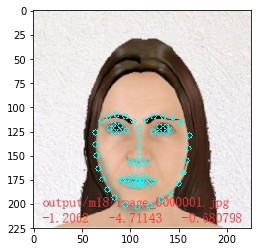

In [40]:
#-------------test--------------------------------------------------
#读取图像
img0 = cv2.imread('18.jpg')
img0=cv2.resize(img0,(225,225))
img = img0[:,:,::-1] # 调节色彩通道
a=annotate_landmarks68(img)
plt.imshow(a)
plt.show()

[[  78.  122.]
 [ 143.  124.]
 [ 109.  151.]
 [ 107.  202.]]


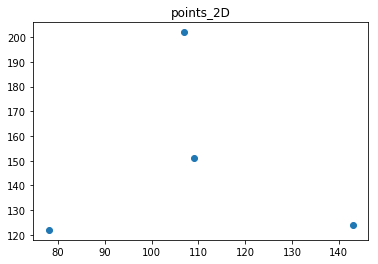

In [41]:
#-------------------------test--------------------------------------
points_2D=get_landmark4(img)
print(points_2D)
plt.scatter(points_2D.T[0],points_2D.T[1])
plt.title('points_2D')
plt.show()

## 2.手动构建4点人脸3D模型

In [42]:
# 手动构建4点人脸3D模型
def model_3D0():
    '''
    手动构建4点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型4点矩阵 shape=(4,3)
    '''
    points_3D = np.array([
        (-225.0, -170.0, -135.0),  # 左眼左眼角
        (225.0, -170.0, -135.0),  # 右眼右眼角
        (0.0, 0.0, 0.0),  # 鼻尖
        (0.0, 330.0, -135.0)  #下巴
    ])
    return points_3D

In [43]:
# 手动构建4点人脸3D模型 我调的 loss大 差异大
def model_3D():
    '''
    手动构建4点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型4点矩阵 shape=(4,3)
    '''
    points_3D = np.array([
        (-225.0, -170.0, 0.0),  # 左眼左眼角
        (225.0, -170.0, 0.0),  # 右眼右眼角
        (0.0, 0.0, 105.0),  # 鼻尖
        (0.0, 170.0, 50.0)  #下巴(0.0, 330.0, 50.0)
    ])
    return points_3D

In [44]:
# 手动构建4点人脸3D模型 学长代码 loss小 差异小
def model_3D2():
    '''
    手动构建4点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型4点矩阵 shape=(4,3)
    '''
    points_3D = np.array([
        (-225.0, -170.0, -135.0),  # 左眼左眼角
        (225.0, -170.0, -135.0),  # 右眼右眼角
        (0.0, 0.0, 0.0),  # 鼻尖
        (0.0, 330.0, -60.0)  #下巴(0.0, 330.0, 50.0)
    ])
    return points_3D

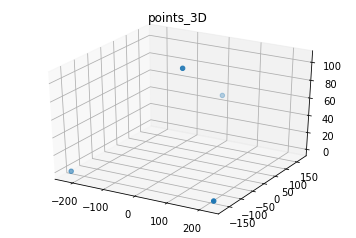

In [45]:
#---------------------------test------------------------------------
points_3D=model_3D()
#print(points_3D)
ax = plt.subplot(111, projection='3d')
ax.scatter(points_3D.T[0],points_3D.T[1],points_3D.T[2])
plt.title('points_3D')
plt.show()

## 3.归一化,去掉平移因子的影响

In [46]:
# 归一化点
def get_normalize(points):
    '''
    归一化点
    :param 手动构建的3D模型(points_3D) 或 dlib检测到的4个特征点(points_2D)
    :return: 归一化后的点矩阵
    '''
    center = np.sum(points, axis=0) / points.shape[0]  # 中心
    L = np.sum(np.sum((points - center) ** 2, axis=1) ** 0.5)  # 归一化系数
    normalize = (points - center) / L
    return normalize, center, L

normalize_3D=
 [[-0.27623969 -0.15653582 -0.04757461]
 [ 0.27623969 -0.15653582 -0.04757461]
 [ 0.          0.05217861  0.08133724]
 [ 0.          0.26089304  0.01381198]]
normalize_2D=
 [[-0.22674953 -0.20135358]
 [ 0.2448895  -0.18684161]
 [-0.001814    0.00906998]
 [-0.01632597  0.37912522]]


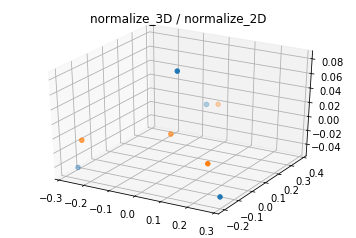

In [47]:
#------------------------------test---------------------------------
normalize_3D,center_3D, L_3D=get_normalize(points_3D)
normalize_2D,center_2D, L_2D=get_normalize(points_2D)
print('normalize_3D=\n',normalize_3D)
print('normalize_2D=\n',normalize_2D)
bx = plt.subplot(111, projection='3d')
bx.scatter(normalize_3D.T[0],normalize_3D.T[1],normalize_3D.T[2])
bx.scatter(normalize_2D.T[0],normalize_2D.T[1])
plt.title('normalize_3D / normalize_2D')
plt.show()

## 4.求投影矩阵P

In [48]:
# 求投影矩阵P
def get_P_matrix(normalize_3D, normalize_2D):
    num = normalize_2D.shape[0]
    _ = 0  # _是要舍弃的值
    if num < 3:
        return -1
    elif num == 3:
        _, r1_T = cv2.solve(normalize_3D.T, normalize_2D.T[0], _)
        _, r2_T = cv2.solve(normalize_3D.T,normalize_2D.T[1], _)
    else:
        _, r1_T = cv2.solve(normalize_3D, normalize_2D.T[0], _, cv2.DECOMP_SVD)  # 奇异值分解
        _, r2_T = cv2.solve(normalize_3D, normalize_2D.T[1], _, cv2.DECOMP_SVD)
    r1 = r1_T.T[0]
    r2 = r2_T.T[0]
    r3 = np.cross(r1, r2)
    P = np.array([r1, r2])
    return P

In [49]:
#------------------------------test---------------------------------
P=get_P_matrix(normalize_3D,normalize_2D)
print('P=\n',P)

P=
 [[ 0.85367717 -0.06355501  0.01846898]
 [ 0.02626699  1.49815997 -0.84957295]]


## 5.优化K

In [104]:
# 定义送入优化器的修正的目标函数
def f(K):
    '''
    修正的目标函数
    :param K: 待优化的参数,K*Z中的K
    :return: 修正的目标函数的值
    '''
    a=1*10**-6
    disparity = (normalize_2D - np.dot(normalize_3D, P.T)).T  # disparity:d=b-P*a
    objective = np.sum(disparity ** 2)  # 目标函数
    # 惩罚函数
    penalty = np.sum((np.ones(4)-K[0:4])**2*normalize_3D.T[0]**2)+\
                np.sum((np.ones(4)-K[4:8])**2*normalize_3D.T[1]**2)+\
                np.sum((np.ones(4)-K[8:12])**2*normalize_3D.T[2]**2)
    revised_objective = objective + a * penalty  # 修正的目标函数
    return revised_objective

In [105]:
#------------------------------test---------------------------------
#K=np.random.random(normalize_3D.shape[0])
K=np.zeros((4,3))#初始化
K_opt=scipy.optimize.fmin_cg(f, K,gtol=1e-10)#共轭梯度下降法
#K_opt=scipy.optimize.leastsq(f, K,gtol=1e-5)#Levenberg–Marquardt算法
print('K_opt=\n',K_opt)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 6062
         Gradient evaluations: 433
K_opt=
 [ 0.99971666  0.99971666  0.          0.          0.99946927  0.99946927
  1.00436271  1.00018307  0.98644857  0.98644857  0.99647551  0.99725748]


In [93]:
#得到K修正后的3D模型(A_K)
def get_normalize_3D_K(normalize_3D, K_opt):
    '''
    计算经K修正的3D模型
    :param normalize_3D: 归一化的3D模型
    :param K_opt: 最优化K
    :return: K修正的3D模型
    '''
    normalize_3D_K = np.array([normalize_3D.T[0]*K_opt[0:4], normalize_3D.T[1]*K_opt[4:8], normalize_3D.T[2] * K_opt[8:12]])
    return normalize_3D_K.T

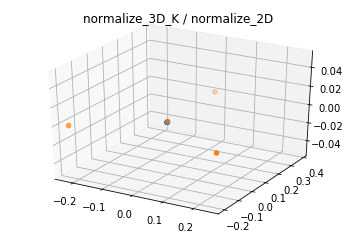

In [94]:
#------------------------------test---------------------------------
normalize_3D_K=get_normalize_3D_K(normalize_3D,K_opt)
cx = plt.subplot(111, projection='3d')
cx.scatter(normalize_3D_K.T[0],normalize_3D_K.T[1],normalize_3D_K.T[2])
cx.scatter(normalize_2D.T[0],normalize_2D.T[1])
plt.title('normalize_3D_K / normalize_2D')
plt.show()

## 6.计算K修正后的最优投影矩阵

In [95]:
# 得到K修正后的最优投影矩阵
def get_P_K_opt(normalize_2D, normalize_3D_K):
    '''
    计算K修正后的最优投影矩阵
    :param normalize_2D: 归一化2D特征点
    :param normalize_3D_K: 归一化K修正3D模型
    :return:最优投影矩阵
    '''
    P_K_opt = np.dot(np.dot(normalize_2D.T, normalize_3D_K), np.linalg.pinv(np.dot(normalize_3D_K.T, normalize_3D_K)))
    return P_K_opt

In [96]:
P_K_opt=get_P_K_opt(normalize_2D, normalize_3D_K)
P_K_opt

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

## 7.根据最优投影矩阵计算欧拉角

In [97]:
# 由最优投影矩阵计算欧拉角
def get_euler_angle(P_K_opt):
    '''
    由最优投影矩阵计算欧拉角
    :param P_opt: 最优投影矩阵
    :return: 欧拉角
    '''
    print('P_K_opt=',P_K_opt)
    theta = np.array([0, 0, 0])  # (theta x,y,z)
    r1 = P_K_opt[0]
    r2 = P_K_opt[1]
    r3 = np.cross(r1, r2)
    
    #强制转化
    if r3[2]==0:
        r3[2]=0.000001
    if r1[0]==0:
        r1[0]=0.000001
        
    #print('r3=', r3)
    theta[0] = -math.atan(r3[1] / r3[2]) / math.pi * 180#论文和data的参考系不一致，前面加负号和data一致
    theta[1] = -math.atan(r3[0] / (r3[1] ** 2 + r3[2] ** 2) ** 0.5) / math.pi * 180
    theta[2] = -math.atan(r2[0] / r1[0]) / math.pi * 180 #论文和data的参考系不一致，前面加负号和data一致
    return theta

In [98]:
#------------------------------test---------------------------------
theta=get_euler_angle(P_K_opt)
print('theta=',theta)

P_K_opt= [[ 0.  0.  0.]
 [ 0.  0.  0.]]
theta= [0 0 0]


## 8.画表示姿势的线

In [99]:
# 画表示姿势的线
def draw_line(img, points_2D,P_K_opt):
    '''
    画表示姿势的线
    :param img: 输入图片
    :param points_2D: dlib提取的2D特征点
    :return: 画有姿势线的图片
    '''
    nose_tip_2D = (int(points_2D[2][0]), int(points_2D[2][1]))
    far_3D = np.array([0.0, 0.0, 1000.0])
    far_2D = np.dot(np.dot(P_K_opt, (far_3D - center_3D) / L_3D), L_2D) + center_2D
    p1 = (int(nose_tip_2D[0]), int(nose_tip_2D[1]))
    p2 = (int(far_2D[0]), int(far_2D[1]))
    #print('p1=', p1, 'p2=', p2)
    img_with_line = np.copy(img)
    cv2.line(img_with_line, p1, p2, (255, 0, 0), 2)
    return img_with_line

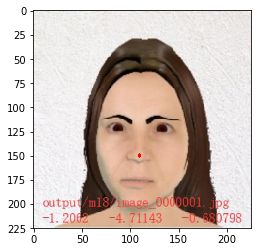

In [100]:
#-----------------test----------------------------------------------
img_with_line=draw_line(img,points_2D,P_K_opt)
plt.imshow(img_with_line)
plt.show()

In [101]:
def get_loss(theta,label):
    return np.sum((label-theta)**2)

In [106]:
#-----------------test----------------------------------------------
label18=[-1.2002,-4.71143,-0.680798]
label=[-3.64614,-17.1319,-2.81734]
print('normalize_2D=\n',normalize_2D)
print('\nnormalize_3D=\n',normalize_3D)
print('\nP=',P)
theta=get_euler_angle(P)
print('\nK_opt=',K_opt)
print('\nnormalize_3D_K=\n',normalize_3D_K)
print('\nP_K_opt=\n',P_K_opt)
theta_opt=get_euler_angle(P_K_opt)
print('\nlabel=',label)
print('\ntheta=',theta)
print('loss=',get_loss(theta,label))
print('theta_opt=',theta_opt)
print('loss=',get_loss(theta_opt,label))

normalize_2D=
 [[-0.22674953 -0.20135358]
 [ 0.2448895  -0.18684161]
 [-0.001814    0.00906998]
 [-0.01632597  0.37912522]]

normalize_3D=
 [[-0.27623969 -0.15653582 -0.04757461]
 [ 0.27623969 -0.15653582 -0.04757461]
 [ 0.          0.05217861  0.08133724]
 [ 0.          0.26089304  0.01381198]]

P= [[ 0.85367717 -0.06355501  0.01846898]
 [ 0.02626699  1.49815997 -0.84957295]]
P_K_opt= [[ 0.85367717 -0.06355501  0.01846898]
 [ 0.02626699  1.49815997 -0.84957295]]

K_opt= [ 0.99971666  0.99971666  0.          0.          0.99946927  0.99946927
  1.00436271  1.00018307  0.98644857  0.98644857  0.99647551  0.99725748]

normalize_3D_K=
 [[-0. -0. -0.]
 [ 0. -0. -0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

P_K_opt=
 [[  1.00000000e-06   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]]
P_K_opt= [[  1.00000000e-06   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]]

label= [-3.64614, -17.1319, -2.81734]

theta= [-29  -1  -1]

# ----------------------------------------------------------------------------------------------------

In [107]:
def F(K):
    print('enter F...:\n')
    P=get_P_matrix(normalize_3D, normalize_2D)
    K_opt=scipy.optimize.fmin_cg(f, K,gtol=1e-5)#共轭梯度下降法
    print('get K_opt\n')
    normalize_3D_K=get_normalize_3D_K(normalize_3D,K_opt)#得到K修正后的3D模型
    P_K_opt=get_P_K_opt(normalize_2D, normalize_3D_K)# 得到K修正后的最优投影矩阵
    theta=get_euler_angle(P_K_opt)# 由最优投影矩阵计算欧拉角
    loss=get_loss(theta,label)
    return loss

In [108]:
K=np.zeros((4,3))#初始化
K_opt=scipy.optimize.fmin_cg(F, K,gtol=1)#共轭梯度下降法
print('K_opt=\n',K_opt)

enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ 0.  0.  0.]
 [ 0.  0.  0.]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ 55085870.12377367         0.                 0.        ]
 [ 48916252.66991101         0.                 0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ 59492739.73367556         0.                 0.        ]
 [-45390756.9819895          0.                 0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
  

         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[-3.58915156  0.          0.        ]
 [ 0.01395941  0.          0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[-3.58915157  0.          0.        ]
 [ 0.01395923  0.          0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[-3.58915145  0.          0.        ]
 [ 0.01395931  0.          0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[-3.58915145  0.          0.        ]
 [ 0.01395931  0.          0

         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -9.66255547e+01   7.09091073e+05   0.00000000e+00]
 [  7.37217195e+01   1.59949692e+08   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -9.73355590e+01   7.71445590e+05   0.00000000e+00]
 [ -8.64339764e+01   1.74015002e+08   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -9.69507071e+01  -2.33304862e+06   0.00000000e+00]
 [  3.77071114e-01   1.16652431e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -9.69507

         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -2.61884731e+03  -4.19948751e+06   0.00000000e+00]
 [  1.01855025e+01   9.75214322e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -2.61006424e+03   0.00000000e+00   2.33313837e+06]
 [  1.99138235e+03   0.00000000e+00   5.26286084e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -2.62924299e+03   0.00000000e+00   2.53830484e+06]
 [ -2.33476777e+03   0.00000000e+00   5.72565491e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -2.61884

 [  1.61398780e+05   1.59949692e+08   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -2.13096501e+05   7.71445590e+05   0.00000000e+00]
 [ -1.89229693e+05   1.74015002e+08   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -2.12253946e+05  -2.33304862e+06   0.00000000e+00]
 [  8.25520868e+02   1.16652431e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -2.12253946e+05  -4.19948751e+06   0.00000000e+00]
 [  8.25520868e+02   9.75214322e+07   0.00000000e+00]]
enter F..

         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.73093902e+07   0.00000000e+00   2.53830484e+06]
 [ -1.53707385e+07   0.00000000e+00   5.72565491e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[-17240951.20313251         0.          -1496672.69770253]
 [    67055.36109981         0.           7483363.48851265]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.72409512e+07   0.00000000e+00  -7.93236530e+07]
 [  6.70553611e+04   0.00000000e+00   1.84207150e+09]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         I

         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -7.97286683e+09   0.00000000e+00   2.53830484e+06]
 [ -7.07990574e+09   0.00000000e+00   5.72565491e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -7.94134317e+09   0.00000000e+00  -1.49667270e+06]
 [  3.08863257e+07   0.00000000e+00   7.48336349e+06]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -7.94134317e+09   0.00000000e+00  -7.93236530e+07]
 [  3.08863257e+07   0.00000000e+00   1.84207150e+09]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations:

         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ 55085247.33249948         0.                 0.        ]
 [ 48922598.72117515         0.                 0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ 59493361.48922206         0.                 0.        ]
 [-45397103.13739935         0.                 0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -8.49940486e+11   0.00000000e+00   0.00000000e+00]
 [  3.30567992e+09   0.00000000e+00   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.91128968e+13   7.71445585e+05   0.00000000e+00]
 [ -1.69722524e+13   1.74015002e+08   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.90373269e+13  -2.33304862e+06   0.00000000e+00]
 [  7.40420187e+10   1.16652431e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.90373269e+13  -4.19948751e+06   0.00000000e+00]
 [  7.40420187e+10   9.75214322e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function

 [  1.65842449e+12   1.16652431e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -4.26406111e+14  -4.19948751e+06   0.00000000e+00]
 [  1.65842449e+12   9.75214322e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -4.24976034e+14   0.00000000e+00   2.33313828e+06]
 [  3.24240974e+14   0.00000000e+00   5.26286084e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -4.28098756e+14   0.00000000e+00   2.53830452e+06]
 [ -3.80151695e+14   0.00000000e+00   5.72565491e+08]]
enter F..

         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -4.52011618e+16   0.00000000e+00   0.00000000e+00]
 [  1.75801218e+14   0.00000000e+00   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ 55085870.11207394         0.                 0.        ]
 [ 48916252.78923202         0.                 0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ 59492739.74537528         0.                 0.        ]
 [-45390757.1013105          0.                 0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.01243480e+18   0.00000000e+00   0.00000000e+00]
 [  3.93767026e+15   0.00000000e+00   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -9.29685838e-03   9.72103590e+07   0.00000000e+00]
 [ -8.25561024e-03   8.63227988e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.09236012e-02  -1.04987188e+08   0.00000000e+00]
 [  8.33430315e-03   8.01013359e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function 

 [        0.          97521432.19088776         0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -4.49365143e-03   0.00000000e+00   3.19853439e+08]
 [ -3.99036247e-03   0.00000000e+00   2.84029854e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -5.27988329e-03   0.00000000e+00  -3.45441715e+08]
 [  4.02835540e-03   0.00000000e+00   2.63559234e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[       0.                0.         -1496672.69770253]
 [       0.                0.          7483363.48851265

         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[        0.          -2333048.61700688         0.        ]
 [        0.          11665243.08503442         0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[        0.          -4199487.51061239         0.        ]
 [        0.          97521432.19088776         0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.22974127e-04   0.00000000e+00   3.19853439e+08]
 [ -1.09201024e-04   0.00000000e+00   2.84029854e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function

         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.76470618e-05  -1.04987188e+08   0.00000000e+00]
 [  1.34640546e-05   8.01013359e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[        0.          -2333048.61700688         0.        ]
 [        0.          11665243.08503442         0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[        0.          -4199487.51061239         0.        ]
 [        0.          97521432.19088776         0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
      

         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.79734276e-05  -1.04987188e+08   0.00000000e+00]
 [  1.37130596e-05   8.01013359e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[        0.          -2333048.61700688         0.        ]
 [        0.          11665243.08503442         0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[        0.          -4199487.51061239         0.        ]
 [        0.          97521432.19088776         0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
      

get K_opt

P_K_opt= [[  0.00000000e+00   0.00000000e+00  -7.93236530e+07]
 [  0.00000000e+00   0.00000000e+00   1.84207150e+09]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -6.11420749e+20   0.00000000e+00   0.00000000e+00]
 [  2.37800331e+18   0.00000000e+00   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -6.11420749e+20   0.00000000e+00   0.00000000e+00]
 [  2.37800331e+18   0.00000000e+00   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ 55085870.1237728          0.             

         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[  0.00000000e+00   0.00000000e+00  -7.93236530e+07]
 [  0.00000000e+00   0.00000000e+00   1.84207150e+09]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -6.11306284e+20   0.00000000e+00   0.00000000e+00]
 [  2.37755813e+18   0.00000000e+00   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -6.11306284e+20   0.00000000e+00   0.00000000e+00]
 [  2.37755813e+18   0.00000000e+00   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
       

         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -6.11246683e+20   0.00000000e+00   0.00000000e+00]
 [  2.37732632e+18   0.00000000e+00   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -6.11246683e+20   0.00000000e+00   0.00000000e+00]
 [  2.37732632e+18   0.00000000e+00   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ 55085870.12377281         0.                 0.        ]
 [ 48916252.66991984         0.                 0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         I

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.95862308e-04   0.00000000e+00  -3.45441715e+08]
 [  1.49435687e-04   0.00000000e+00   2.63559234e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[       0.                0.         -1496672.69770253]
 [       0.                0.          7483363.48851265]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[  0.00000000e+00   0.00000000e+00  -7.93236530e+07]
 [  0.00000000e+00   0.00000000e+00   1.84207150e+09]]
enter F...:

Optimization terminated successfully.
         Current fun

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.95862308e-04   0.00000000e+00  -3.45441715e+08]
 [  1.49435687e-04   0.00000000e+00   2.63559234e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[       0.                0.         -1496672.69770253]
 [       0.                0.          7483363.48851265]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[  0.00000000e+00   0.00000000e+00  -7.93236530e+07]
 [  0.00000000e+00   0.00000000e+00   1.84207150e+09]]
enter F...:

Optimization terminated successfully.
         Current fun

         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -6.11230521e+20   0.00000000e+00   0.00000000e+00]
 [  2.37726346e+18   0.00000000e+00   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.54117155e-05   9.72103590e+07   0.00000000e+00]
 [ -1.36856034e-05   8.63227988e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.80899868e-05  -1.04987188e+08   0.00000000e+00]
 [  1.38019899e-05   8.01013359e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations:


P_K_opt= [[ -1.54009230e-05   9.72103590e+07   0.00000000e+00]
 [ -1.36760196e-05   8.63227988e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.80899868e-05  -1.04987188e+08   0.00000000e+00]
 [  1.38019899e-05   8.01013359e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[        0.          -2333048.61700688         0.        ]
 [        0.          11665243.08503442         0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[        0.          -4199487.51061239   

         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.66688002e-04   0.00000000e+00   3.19853439e+08]
 [ -1.48018946e-04   0.00000000e+00   2.84029854e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.95747253e-04   0.00000000e+00  -3.45441715e+08]
 [  1.49347904e-04   0.00000000e+00   2.63559234e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[       0.                0.         -1496672.69770253]
 [       0.                0.          7483363.48851265]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evalua

         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ 55085870.12377281         0.                 0.        ]
 [ 48916252.66991984         0.                 0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ 59492739.73367643         0.                 0.        ]
 [-45390756.98199832         0.                 0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -6.11230307e+20   0.00000000e+00   0.00000000e+00]
 [  2.37726263e+18   0.00000000e+00   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function

         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.95862308e-04   0.00000000e+00  -3.45441715e+08]
 [  1.49435687e-04   0.00000000e+00   2.63559234e+08]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[       0.                0.         -1496672.69770253]
 [       0.                0.          7483363.48851265]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[  0.00000000e+00   0.00000000e+00  -7.93236530e+07]
 [  0.00000000e+00   0.00000000e+00   1.84207150e+09]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -6

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[       0.                0.         -1496672.69770253]
 [       0.                0.          7483363.48851265]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[  0.00000000e+00   0.00000000e+00  -7.93236530e+07]
 [  0.00000000e+00   0.00000000e+00   1.84207150e+09]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -6.11230306e+20   0.00000000e+00   0.00000000e+00]
 [  2.37726262e+18   0.00000000e+00   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current fun

enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[ -1.80899868e-05  -1.04987188e+08   0.00000000e+00]
 [  1.38019899e-05   8.01013359e+07   0.00000000e+00]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[        0.          -2333048.61700688         0.        ]
 [        0.          11665243.08503442         0.        ]]
enter F...:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 14
         Gradient evaluations: 1
get K_opt

P_K_opt= [[        0.          -4199487.51061239         0.        ]
 [        0.          97521432.19088776         0.        ]]
enter F...:

Optimization terminated suc